# Do / To Do

In [1]:
# 2022-12-21
## Do - 오전 : 데이터탐색 리뷰, 프로젝트 주제 타당성 검토, 데이터 및 기술타당성 검토, 계획서 작성 및 제출
## Do - 오후 : 딥러닝 모델 준비 - OutPut이 2종류인 이미지 분류 Sequential 모델 작성 (중)
## To Do : 딥러닝 Sequential 모델 완성 / CNN 모델 추가 / 객체탐지 attatch / Mobile - Code 간 연동

# 2022-12-22
## Do - 오전 : 이미지 리사이징 기술 탐색
## Do - 오후 : 다중 출력 딥러닝 모델 (Dense) 완성
## To Do : 다중출력모델 - CNN 모델 추가 / 테스트 데이터 크롤링 / 객체탐지 attatch / Mobile - Code 간 연동

# 2022-12-23
## Do - 오전 : 다중출력모델 - CNN 모델 완성 / train 데이터 추가 수집 논의
## Do - 오후 : 코드 베이스라인 완성 / train 데이터 추가 수집
## To Do : 모델 최적화 / 객체탐지 attatch / Mobile - Code 간 연동 / 발표준비

# 배움

In [2]:
# softmax : 모든 변수 확률값의 합이 1
# sigmoid : 0 ~ 1 사이 값을 가짐??

In [3]:
# loss 함수
## spares_..._crossentropy : 원 핫 인코딩에 대한 로스
## ..._crossentropy : 레이블 인코딩에 대한 로스

In [ ]:
# 레퍼런스
# https://nicola-ml.tistory.com/123

In [ ]:
# 에러
# https://m.blog.naver.com/bubilife/222086400331

# 사전 준비 (Import, Mount)

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import glob as glob
import cv2
from tqdm import tqdm

In [3]:
# ◼︎◼︎◼︎◼︎◼︎◼︎ 데이터 경로 선언 (1) 구글드라이브 ◼︎◼︎◼︎◼︎◼︎◼︎

from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/딥러닝_프로젝트_과채어때컴퍼니조/data/'

# 구글 드라이브 공유 드라이브 마운트 방법
# 구글 드라이브 -> 공유드라이브 오른쪽 클릭 -> 바로가기 추가 -> My Drive에 추가
# https://sundries-in-myidea.tistory.com/96

ModuleNotFoundError: No module named 'google.colab'

In [2]:
# ◼︎◼︎◼︎◼︎◼︎◼︎ 데이터 경로 선언 (2) Local ◼︎◼︎◼︎◼︎◼︎◼︎

path = '/Users/jongya/Desktop/data/data/'

# 데이터 준비

## data preperence

In [3]:
class dataset:
    
    # 인코딩 값 Notice
    fresh = ['stale', 'fresh']
    kind = ['apple', 'banana', 'bittergourd', 'capsicum', 'orange', 'tomato']


    def load_data():
        # 모든 이미지 경로명 데이터를 리스트로 담아 뽑기
        img_list_png = glob.glob(path + '*/*/*.png', recursive=True)
        img_list_jpg = glob.glob(path + '*/*/*.jpg', recursive=True)
        img_list_jpeg = glob.glob(path + '*/*/*.jpeg', recursive=True)
        img_list = img_list_png + img_list_jpg + img_list_jpeg
        return img_list
  

    def label_split(img_list):
        # 레이블 종류별로 나누기 (fresh, kind)
        fresh_list =  []
        kind_list =  []
        for i in img_list:
            fresh_list.append(i.split('/')[-2].split('_')[0])
            kind_list.append(i.split('/')[-2].split('_')[1])
        return fresh_list, kind_list
    

    def label_encoding(kind_or_fresh_list):
    # 레이블 인코딩
        label = list(set(kind_or_fresh_list))
        label.sort()
        df = kind_or_fresh_list.copy()
        for i, j in enumerate(df):
            for n, m in enumerate(label):
                if j == m:
                    df[i] = n
        itemlist = pd.DataFrame(list(range(len(label))), label)
        # 인코딩된 array와 함께, itemlist 반환
        return np.array(df), itemlist

  
    def train_val_test(train_test_rate=0.3, train_val_rate=0.2):
        # train - val - test 데이터셋 분리
        from sklearn.model_selection import train_test_split
        import numpy as np

        globals()['img_list'] = dataset.load_data()
        fresh_list, kind_list = dataset.label_split(img_list)
        globals()['fresh_list'], globals()['kind_list'] = dataset.label_split(img_list)
        fresh_list, globals()['fresh_items'] = dataset.label_encoding(fresh_list)
        kind_list, globals()['kind_items'] = dataset.label_encoding(kind_list)
        
        df = pd.DataFrame([img_list, fresh_list, kind_list]).T

        ## x data
        train, test = train_test_split(df, test_size = train_test_rate)
        train, val = train_test_split(df, test_size = train_val_rate)
        
        return train, val, test


    def view_sample_img(img_list, sample_size=6):
        # img list에서 샘플 이미지 보기
        import random
        import matplotlib.pyplot as plt
        from keras.utils import img_to_array
        from PIL import Image
        rand_idx = random.sample(img_list, sample_size)
        fig = plt.figure(figsize=(10,10))
        fig.suptitle(f'Predict / size = {sample_size}')
        for i, j in enumerate(rand_idx):
            img_path = j
            plt.subplot(int(sample_size/3),3,i+1)
            plt.xticks([])
            plt.yticks([])
            plt.xlabel(j.split('/')[7])
            plt.imshow(Image.open(j))
        plt.tight_layout()
        plt.show()
    
    
    def view_test_img(pred_df, sample_size=6):
        # img list에서 샘플 이미지 보기
        import random
        import matplotlib.pyplot as plt
        from keras.utils import img_to_array
        from PIL import Image
        rand_idx = np.random.randint(1, len(pred_df), sample_size)
        fig = plt.figure(figsize=(10,10))
        fig.suptitle(f'samples / size = {sample_size}')
        for i, j in enumerate(rand_idx):
            plt.subplot(int(sample_size/3),3,i+1)
            plt.xticks([])
            plt.yticks([])
            plt.xlabel(f' fresh_answer : {pred_df["신선도"].iloc[j]}\n'+\
                       f' fresh_predict : {pred_df["신선도예측"].iloc[j]}\n'+\
                       f' kind_answer : {pred_df["종류"].iloc[j]}\n'+\
                       f' kind_predict : {pred_df["종류예측"].iloc[j]}\n')
            plt.imshow(Image.open(pred_df['파일명'].iloc[j]))
        plt.tight_layout()
        plt.show()
    
    


In [4]:
# ◼︎◼︎◼︎◼︎◼︎◼︎ train, val, test 셋 분리 ◼︎◼︎◼︎◼︎◼︎◼︎
## 입력 : img_list (이미지 경로 리스트)
## 반환 : 분할된 데이터 (데이터프레임, 0칼럼 - 이미지 경로명, 1칼럼 - encodinge된 fresh label, 2칼럼 - encoding된 kind label)

img_list = dataset.load_data()
train, val, test = dataset.train_val_test(0.3, 0.2)

In [13]:
# ◼︎◼︎◼︎◼︎◼︎◼︎ itemlist(label) 확인 ◼︎◼︎◼︎◼︎◼︎◼︎
kind_items, fresh_items

(              0
 apple         0
 banana        1
 broccoli      2
 capsicum      3
 cherryTomato  4
 grape         5
 mandarin      6
 orange        7
 pepper        8
 strawberry    9,
        0
 fresh  0
 stale  1)

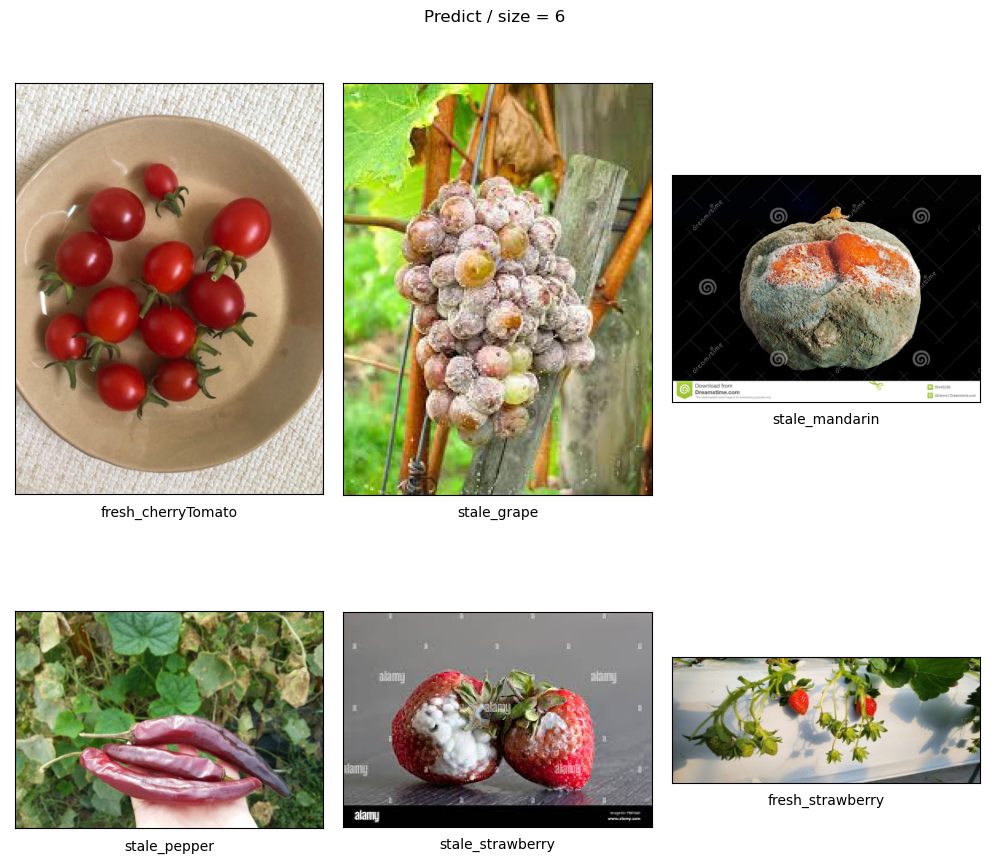

In [14]:
# ◼︎◼︎◼︎◼︎◼︎◼︎ 랜덤 이미지 확인 ◼︎◼︎◼︎◼︎◼︎◼︎
dataset.view_sample_img(img_list)

## Image Generator

이미지 처리는 두 가지 방법 중 하나를 선택해주시면 됩니다.  
(1) image generator 방식  
(2) resize 방식  

<u>*이하 코드는 Image generator 방식으로 작성됐습니다.*</u>

In [15]:
# ◼︎◼︎◼︎◼︎◼︎◼︎ 이미지 사이즈 정의 ◼︎◼︎◼︎◼︎◼︎◼︎

width = 120
height = 120
channel = 3

In [102]:
# 방법 1-1 : ◼︎◼︎◼︎◼︎◼︎◼︎ 이미지 제너레이터 (변환) ◼︎◼︎◼︎◼︎◼︎◼︎
from keras.preprocessing.image import ImageDataGenerator

# 이미지 제너레이터 선언
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   shear_range=0.5,
                                   brightness_range=[0.5,1.5],
                                   zoom_range=0.2,
                                   width_shift_range= 0.1,
                                   height_shift_range=0.1,
                                   rotation_range=30,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale = 1./255,
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                 shear_range=0.5,
                                 brightness_range=[0.5,1.5],
                                 zoom_range=0.2,
                                 width_shift_range= 0.1,
                                 height_shift_range=0.1,
                                 rotation_range=30,
                                 fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale = 1./255)


# train, validataion 제너레이터 선언
train_generator = train_datagen.flow_from_dataframe(train,
                                                    target_size=(width, height),
                                                    x_col=0,
                                                    y_col=[1, 2],
                                                    color_mode = 'rgb',
                                                    class_mode = 'multi_output', # Multi_output : 다중 출력모델
                                                    batch_size = 1,
                                                    shuffle = True)


val_generator = val_datagen.flow_from_dataframe(val,  
                                                target_size=(width, height),
                                                x_col=0,
                                                y_col=[1, 2],
                                                color_mode = 'rgb',
                                                class_mode = 'multi_output',
                                                batch_size = 1,
                                                shuffle = True)

test_generator = test_datagen.flow_from_dataframe(test,  
                                                target_size=(width, height),
                                                x_col=0,
                                                y_col=[1, 2],
                                                color_mode = 'rgb',
                                                class_mode = 'multi_output',
                                                batch_size = 1,
                                                shuffle = False)

Found 3980 validated image filenames.
Found 995 validated image filenames.
Found 1493 validated image filenames.


In [128]:
# 방법 1-2 : ◼︎◼︎◼︎◼︎◼︎◼︎ 이미지 제너레이터 (변환 안함) ◼︎◼︎◼︎◼︎◼︎◼︎
from keras.preprocessing.image import ImageDataGenerator

# 이미지 제너레이터 선언
train_datagen = ImageDataGenerator(rescale = 1./255,)
val_datagen = ImageDataGenerator(rescale = 1./255,)
test_datagen = ImageDataGenerator(rescale = 1./255)


# train, validataion 제너레이터 선언
train_generator = train_datagen.flow_from_dataframe(train,
                                                    target_size=(width, height),
                                                    x_col=0,
                                                    y_col=[1, 2],
                                                    color_mode = 'rgb',
                                                    class_mode = 'multi_output', # Multi_output : 다중 출력모델
                                                    batch_size = 1,
                                                    shuffle = True)


val_generator = val_datagen.flow_from_dataframe(val,  
                                                target_size=(width, height),
                                                x_col=0,
                                                y_col=[1, 2],
                                                color_mode = 'rgb',
                                                class_mode = 'multi_output',
                                                batch_size = 1,
                                                shuffle = True)

test_generator = test_datagen.flow_from_dataframe(test,  
                                                target_size=(width, height),
                                                x_col=0,
                                                y_col=[1, 2],
                                                color_mode = 'rgb',
                                                class_mode = 'multi_output',
                                                batch_size = 1,
                                                shuffle = False)

Found 3980 validated image filenames.
Found 995 validated image filenames.
Found 1493 validated image filenames.


In [129]:
# 방법 2 : 리사이징
class image_prep:
    
    def img_resize_and_array(img_path_list, size=(width, height)):
        # 이미지 리사이징 함수
        resized = []
        for i in img_path_list:
            from PIL import Image
            img = Image.open(i)
            resized.append(np.array(img.resize(size).convert('RGB'))*1./255)
        return resized

# 모델 선언

In [130]:
def Sequential_Dense_Model_1():
    from keras.layers import Input, Dense, Flatten, Concatenate
    # from keras.layers import Resizing
    from keras.models import Model

    # inputs = Resizing(width, height, name='inputs')

    inputs = Input((width, height, channel), name='inputs')

    flat = Flatten()(inputs)

    fresh_1 = Dense(1024, activation='relu')(flat)
    fresh_2 = Dense(256, activation='relu')(fresh_1)

    kind_1 = Dense(1024, activation='relu')(flat)
    kind_2 = Dense(256, activation='relu')(kind_1)

    concat = Concatenate()([fresh_2, kind_2])

    fresh_output = Dense(len(set(fresh_list))-1, activation='sigmoid', name='fresh_output')(concat)
    kind_output = Dense(len(set(kind_list)), activation='sigmoid', name='kind_output')(kind_2)

    return Model(inputs = inputs, outputs = [fresh_output, kind_output])

In [131]:
def Sequential_Dense_Model_2():
    
    # score (val-fresh-acc / val-kind-acc)
    # activation : fresh : sigmoid, kind : sigmoid
    ## fresh264-264, kind1024-128 : 7424  / 6245
    ## fresh256-128, kind1024-128 :7380 / 8122
    
    # fresh-rotten은 유닛을 적당히 가져가는 게 정확도 높음
    # kind는 유닛을 많이 가져가는 게 정확도 높음
    # Sequential1 모델보다 2 모델의 정확도 높음
    
    from keras.layers import Input, Dense, Flatten, Concatenate
    # from keras.layers import Resizing
    from keras.models import Model

    # inputs = Resizing(width, height, name='inputs')

    inputs = Input((width, height, channel), name='inputs')

    flat = Flatten()(inputs)

    fresh_1 = Dense(256, activation='relu')(flat)
    fresh_2 = Dense(128, activation='relu')(fresh_1)

    kind_1 = Dense(1024, activation='relu')(flat)
    kind_2 = Dense(128, activation='relu')(kind_1)

    # concat = Concatenate()([fresh_2, kind_2])

    fresh_output = Dense(len(set(fresh_list))-1, activation='sigmoid', name='fresh_output')(fresh_2)
    kind_output = Dense(len(set(kind_list)), activation='sigmoid', name='kind_output')(kind_2)

    return Model(inputs = inputs, outputs = [fresh_output, kind_output])

In [132]:
def CNN_Model_1():
    from keras.layers import Conv2D, MaxPool2D, Flatten, Concatenate, Input, Dense
    from keras.models import Model
    
    # score (val-fresh-acc / val-kind-acc)
    # activation : fresh - softmax / kind - sigmoid
    ## 배치사이즈 32 : 6245 / 2838
    ## 배치사이즈 128 : 5153 / 3362
    
    inputs = Input(shape=(width, height, channel),name='inputs')

    conv = Conv2D(128,(3,3),activation='relu',name='conv2d')(inputs)
    pool = MaxPool2D((2,2),name='maxpool')(conv)
    flat = Flatten(name='flatten')(pool)

    flat_inputs = Flatten(name='flatten2')(inputs)
    concat = Concatenate()([flat,flat_inputs])
    fresh_output = Dense(len(set(fresh_list))-1,activation='softmax',name='fresh_output')(flat_inputs)
    kind_output = Dense(len(set(kind_list)),activation='sigmoid',name='kind_output')(concat)

    return Model(inputs=inputs,outputs=[fresh_output,kind_output])

In [133]:
def CNN_Model_2():
    from keras.layers import Conv2D, MaxPool2D, Flatten, Concatenate, Input, Dense
    from keras.models import Model
    
    # score (val-fresh-acc / val-kind-acc)
    # activation : fresh - softmax / kind - sigmoid
    ## 배치사이즈 32 : 6245 / 2838
    ## 배치사이즈 128 : 5153 / 3362
    
    inputs = Input(shape=(width, height, channel),name='inputs')

    conv = Conv2D(128,(3,3),activation='relu',name='conv2d')(inputs)
    pool = MaxPool2D((2,2),name='maxpool')(conv)
    
    conv2 = Conv2D(64,(3,3),activation='relu',name='conv2d2')(pool)
    pool2 = MaxPool2D((2,2),name='maxpool2')(conv2)
    flat2 = Flatten(name='flatten2')(pool2)

    conv3 = Conv2D(64,(3,3),activation='relu',name='conv2d3')(inputs)
    pool3 = MaxPool2D((2,2),name='maxpool3')(conv3)
    flat3 = Flatten(name='flatten3')(pool3)
    dense = Dense(10, activation='relu', name='dense')(flat3)
    
    concat = Concatenate()([flat2,dense])
    fresh_output = Dense(len(set(fresh_list))-1,activation='softmax',name='fresh_output')(dense)
    kind_output = Dense(len(set(kind_list)),activation='sigmoid',name='kind_output')(concat)

    return Model(inputs=inputs,outputs=[fresh_output,kind_output])

In [134]:
def MixModel_1():
    from keras.layers import Conv2D, MaxPool2D, Flatten, Concatenate, Input, Dense
    from keras.models import Model
    
    # score (val-fresh-acc / val-kind-acc)
    # activation : fresh - softmax / kind - sigmoid
    ## 배치사이즈 32 : 6245 / 2838
    ## 배치사이즈 128 : 5153 / 3362
    
    inputs = Input(shape=(width, height, channel),name='inputs')

    conv = Conv2D(128,(3,3),activation='relu',name='conv2d')(inputs)
    pool = MaxPool2D((2,2),name='maxpool')(conv)
    flat = Flatten(name='flatten')(pool)
    kind_dense_1 = Dense(128, activation = 'relu')(flat)
    kind_dense_2 = Dense(64, activation = 'relu')(kind_dense_1)

    flat_inputs = Flatten(name='flatten2')(inputs)
    fresh_dense_1 = Dense(256, activation = 'relu')(flat_inputs)
    fresh_dense_2 = Dense(128, activation = 'relu')(fresh_dense_1)
    
    concat = Concatenate()([kind_dense_2,flat_inputs])
    fresh_output = Dense(len(set(fresh_list))-1,activation='sigmoid',name='fresh_output')(fresh_dense_2)
    kind_output = Dense(len(set(kind_list)),activation='sigmoid',name='kind_output')(concat)

    return Model(inputs=inputs,outputs=[fresh_output,kind_output])
    

In [135]:
def CNN_Model_3():
    from keras.layers import Conv2D, MaxPool2D, Flatten, Concatenate, Input, Dense
    from keras.models import Model
    
    # score (val-fresh-acc / val-kind-acc)
    # activation : fresh - softmax / kind - sigmoid
    ## 배치사이즈 32 : 6245 / 2838
    ## 배치사이즈 128 : 5153 / 3362
    
    inputs = Input(shape=(width, height, channel),name='inputs')

    conv = Conv2D(128,(3,3),activation='relu',name='conv2d')(inputs)
    pool = MaxPool2D((2,2),name='maxpool')(conv)
    
    conv2 = Conv2D(64,(3,3),activation='relu',name='conv2d2')(pool)
    pool2 = MaxPool2D((2,2),name='maxpool2')(conv2)

    
    flat = Flatten(name='flatten3')(pool2)
    
    
    dense128 = Dense(128, activation='relu', name='dense128')(flat)
    dense64 = Dense(64, activation='relu', name='dense64')(dense128)
    
    
    f_flat = Flatten()(pool)
    f_dense16 = Dense(32, activation='relu', name='dense16_f')(f_flat)
    
    fresh_output = Dense(len(set(fresh_list))-1,activation='sigmoid',name='fresh_output')(f_dense16)
    
    
    concat = Concatenate()([dense64,f_flat])
    
    kind_output = Dense(len(set(kind_list)), activation='softmax',name='kind_output')(concat)
    
    
    globals()['fresh_loss'] = 'binary_crossentropy'
    globals()['kind_loss'] = 'sparse_categorical_crossentropy'
    globals()['metrics'] = ['accuracy']
    

    
    

    return Model(inputs=inputs,outputs=[fresh_output,kind_output])

# 모델 선택

In [136]:
# ◼︎◼︎◼︎◼︎◼︎◼︎ 모델 선택 ◼︎◼︎◼︎◼︎◼︎◼︎
model = MixModel_1()

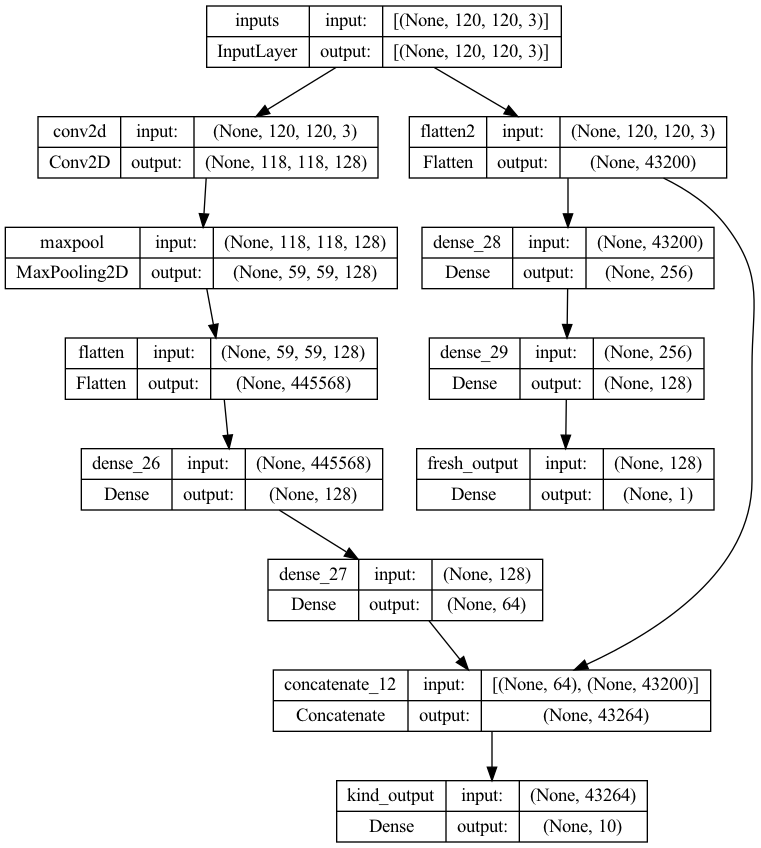

In [137]:
# ◼︎◼︎◼︎◼︎◼︎◼︎ 모델 살펴보기 ◼︎◼︎◼︎◼︎◼︎◼︎
from keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

# 컴파일

In [138]:
# ◼︎◼︎◼︎◼︎◼︎◼︎ 하이퍼 파라미터 ◼︎◼︎◼︎◼︎◼︎◼︎

from keras.optimizers import Adam, RMSprop, Adadelta, Adagrad, Adamax
from keras.metrics import RootMeanSquaredError

optimizer = Adam(learning_rate = 0.001)

fresh_loss = 'binary_crossentropy'
kind_loss = 'sparse_categorical_crossentropy'
metrics = ['acc']

In [139]:
# ◼︎◼︎◼︎◼︎◼︎◼︎ 컴파일 ◼︎◼︎◼︎◼︎◼︎◼︎

model.compile(optimizer = optimizer,
              loss = {'fresh_output' : fresh_loss, 'kind_output' : kind_loss},
              metrics = metrics)

# 학습

이미지 생성 방법에 따라 각기 다른 학습 방법을 사용해줘야 합니다.  
(1) image generator 방식  
(2) resize 방식  

In [140]:
# ◼︎◼︎◼︎◼︎◼︎◼︎ 하이퍼 파라미터 ◼︎◼︎◼︎◼︎◼︎◼︎

epochs = 30
batch_size = 16
spe_train = len(train)/batch_size if len(train)%batch_size == 0 else len(train)/batch_size + 1
spe_val = len(train)/batch_size if len(train)%batch_size == 0 else len(train)/batch_size + 1
# class_weight = {'apple' : 1,
#                 'banana' : 1,
#                 'capsicum' : 1.2,
#                 'orange' : 1,
#                 'tomato' : 1.5,
#                 'apple' : 1,}

In [141]:
# ◼︎◼︎◼︎◼︎◼︎◼︎ 학습 방법 (1) image generatory ◼︎◼︎◼︎◼︎◼︎◼︎
history = model.fit(train_generator,
                    steps_per_epoch = spe_train,
                    validation_data = val_generator,
                    validation_steps = spe_val,
                    epochs = epochs)

Epoch 1/30
249/249 [==============================] - 26s 104ms/step - loss: 41.2496 - fresh_output_loss: 5.6113 - kind_output_loss: 35.6383 - fresh_output_acc: 0.5520 - kind_output_acc: 0.1880 - val_loss: 35.4455 - val_fresh_output_loss: 0.6060 - val_kind_output_loss: 34.8395 - val_fresh_output_acc: 0.7000 - val_kind_output_acc: 0.1640
Epoch 2/30
249/249 [==============================] - 26s 106ms/step - loss: 32.5348 - fresh_output_loss: 1.3186 - kind_output_loss: 31.2162 - fresh_output_acc: 0.5720 - kind_output_acc: 0.2360 - val_loss: 27.2601 - val_fresh_output_loss: 3.2882 - val_kind_output_loss: 23.9719 - val_fresh_output_acc: 0.3880 - val_kind_output_acc: 0.2120
Epoch 3/30
249/249 [==============================] - 26s 103ms/step - loss: 40.8951 - fresh_output_loss: 1.5152 - kind_output_loss: 39.3799 - fresh_output_acc: 0.5560 - kind_output_acc: 0.2400 - val_loss: 26.2916 - val_fresh_output_loss: 0.6765 - val_kind_output_loss: 25.6151 - val_fresh_output_acc: 0.6280 - val_kind_ou

In [32]:
# ◼︎◼︎◼︎◼︎◼︎◼︎ 학습 방법 (2) resize 사용 ◼︎◼︎◼︎◼︎◼︎◼︎
# history = model.fit({'inputs' : np.array(image_prep.img_resize_and_array(x_train))},
#                     {'fresh_output' : np.array(y_train_fresh),
#                      'kind_output' : np.array(y_train_kind)},
#                     validation_data = ({'inputs' : np.array(image_prep.img_resize_and_array(x_val))},
#                                        {'fresh_output' : np.array(y_val_fresh), 'kind_output' : np.array(y_val_kind)}),
#                     epochs = epochs,)

# Score

<center>차수</center>

|차수|이미지|이미지gen방식|이미지사이즈|dt_split|epochs|최고모델|fresh_acc|kind_acc|비고|
|--|--|--|--|--|--|--|--|--|--|
|1차|unique|resize|112x112|0.56:0.14:0.3|50|CNN_1|4323|2707|데이터 부족으로 최고, 최저점 차이 큼|
|2차|unique|resize|112x112|0.56:0.14:0.3|50|CNN_1|4279|9258|운좋게 데이터셋 잘 분류된 것으로 보임|
|3차|unique|resize|112x112|0.8:0.2:0.01|50|CNN_1|4630|3241|데이터 부족으로 최고, 최저점 차이 큼|
|4차|unique|resize|112x112|0.8:0.2:0.01|50|CNN_1|4259|9290|운좋게 데이터셋 잘 분류된 것으로 보임|
|5차|unique|resize|112x112|0.8:0.2:0.01|50|CNN_1|4259|9321|조금의 성능 상승이 있으나.. 양질 데이터 대량 필요|
|6차|unique|resize|256x256|0.8:0.2:0.01|50|CNN_1|4259|9136|너무 오래걸림|
|7차|unique|generator|256x256|0.8:0.2:0.01|50|CNN_1|4416|9954|6차와 같은 이미지크기, 시간 반정도로 줄어듦(generator)|
|8차|total|generator|100x100|0.8:0.2:0.01|50|CNN_1||||


<center>Dense</center>

|차수|모델|1층|유닛수|활성화 함수|2층|유닛수|활성화 함수|3층|유닛수|활성화 함수|출력층|활성화 함수|점수|fresh_acc|kind_acc|time(s)|
|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|
|1차|Sequential_2|Dense|(256, 1024)|(relu, relu)|Dense|(128,128)|(relu, relu)|NA|NA|NA|Dense|(sigmoid,sigmoid)|점수|2183|2707|150s|
|2차|Sequential_2|Dense|(256, 1024)|(relu, relu)|Dense|(128,128)|(relu, relu)|NA|NA|NA|Dense|(sigmoid,sigmoid)|점수|2183|7686|150s|
|3차|Sequential_2|Dense|(256, 1024)|(relu, relu)|Dense|(128,128)|(relu, relu)|NA|NA|NA|Dense|(sigmoid,sigmoid)|점수|1420|2623|150s|
|4차|Sequential_2|Dense|(256, 1024)|(relu, relu)|Dense|(128,128)|(relu, relu)|NA|NA|NA|Dense|(sigmoid,sigmoid)|점수|1667|7315|150s|


<center>CNN</center>

|차수|모델|1층|배치사이즈|활성화 함수|2층|배치사이즈|활성화 함수|3층|배치사이즈|활성화 함수|출력층|활성화 함수|점수|fresh_acc|kind_acc|time(s)|
|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|
|1차|CNN_1|Conv2D|128|relu|MaxPool2D|NA|NA|NA|NA|NA|Dense|(softmax,sigmoid)|점수|4323|2707|150s|
|2차|CNN_1|Conv2D|128|relu|MaxPool2D|NA|NA|NA|NA|NA|Dense|(softmax,sigmoid)|점수|4279|9258|150s|
|3차|CNN_1|Conv2D|128|relu|MaxPool2D|NA|NA|NA|NA|NA|Dense|(softmax,sigmoid)|점수|4630|3241|210s|
|4차|CNN_1|Conv2D|128|relu|MaxPool2D|NA|NA|NA|NA|NA|Dense|(softmax,sigmoid)|점수|4259|9290|210s|
|5차|CNN_1|Conv2D|128|relu|MaxPool2D|NA|NA|(Conv2D, Dense)|(64,10)|relu|Dense|(softmax,sigmoid)|점수|4259|9290|210s|
|6차|CNN_1|Conv2D|128|relu|MaxPool2D|NA|NA|(Conv2D, Dense)|(64,10)|relu|Dense|(softmax,sigmoid)|점수|4259|9136|3600s|
|7차|CNN_1|Conv2D|128|relu|MaxPool2D|NA|NA|(Conv2D, Dense)|(64,10)|relu|Dense|(softmax,sigmoid)|점수|4416|9954|1700s|
|8차|CNN_1|Conv2D|128|relu|MaxPool2D|NA|NA|(Conv2D, Dense)|(64,10)|relu|Dense|(softmax,sigmoid)|점수||||

# 평가

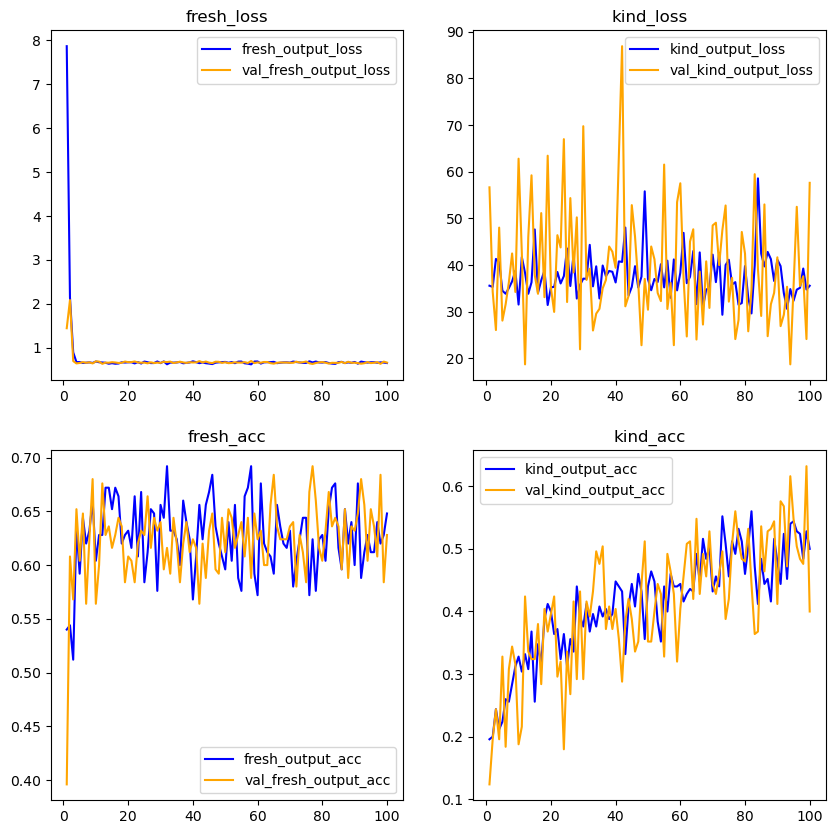

In [116]:
# ◼︎◼︎◼︎◼︎◼︎◼︎ (1) 모델 평가 ◼︎◼︎◼︎◼︎◼︎◼︎
import matplotlib.pyplot as plt

his_dict = history.history
loss = his_dict['fresh_output_loss']
val_loss = his_dict['val_fresh_output_loss']

epochs = range(1,len(loss)+1)
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(2,2,1)
ax1.plot(epochs,loss,color='blue',label='fresh_output_loss')
ax1.plot(epochs,val_loss,color='orange',label='val_fresh_output_loss')
ax1.set_title('fresh_loss')
ax1.legend()

loss = his_dict['kind_output_loss']
val_loss = his_dict['val_kind_output_loss']

ax2 = fig.add_subplot(2,2,2)
ax2.plot(epochs,loss,color='blue',label='kind_output_loss')
ax2.plot(epochs,val_loss,color='orange',label='val_kind_output_loss')
ax2.set_title('kind_loss')
ax2.legend()

acc = his_dict['fresh_output_acc']
val_acc = his_dict['val_fresh_output_acc']

ax3 = fig.add_subplot(2,2,3)
ax3.plot(epochs,acc,color='blue',label='fresh_output_acc')
ax3.plot(epochs,val_acc,color='orange',label='val_fresh_output_acc')
ax3.set_title('fresh_acc')
ax3.legend()


acc = his_dict['kind_output_acc']
val_acc = his_dict['val_kind_output_acc']

ax4 = fig.add_subplot(2,2,4)
ax4.plot(epochs,acc,color='blue',label='kind_output_acc')
ax4.plot(epochs,val_acc,color='orange',label='val_kind_output_acc')
ax4.set_title('kind_acc')
ax4.legend()

plt.show()

In [119]:
# ◼︎◼︎◼︎◼︎◼︎◼︎ (2-1) 예측값 metric ◼︎◼︎◼︎◼︎◼︎◼︎
evaluated = model.evaluate(test_generator)

1493/1493 [==============================] - 12s 8ms/step - loss: 49.1153 - fresh_output_loss: 0.6555 - kind_output_loss: 48.4596 - fresh_output_acc: 0.6363 - kind_output_acc: 0.4910


In [117]:
# ◼︎◼︎◼︎◼︎◼︎◼︎ (2-2) 예측값과 metric 상세 ◼︎◼︎◼︎◼︎◼︎◼︎
# predict_correct.csv 파일로 저장됨
pred = [model.predict(test_generator[i][0], verbose=0) for i in tqdm(range(len(test_generator)))]

ans_fresh = test[0].str.split('/').str[7].str.split('_').str[0].to_list()
ans_kind = test[0].str.split('/').str[7].str.split('_').str[1].to_list()
pred_fresh = [fresh_items[fresh_items[0] == pred[i][0][0][0].round().astype(int)].index[0] for i in range(len(test))]
pred_kind = [kind_items[kind_items[0] == pred[i][1][0].argmax()].index[0] for i in range(len(test))]
pred_df = pd.DataFrame([ans_fresh, pred_fresh, ans_kind, pred_kind, test[0].to_list()]).T
pred_df.columns = ['신선도', '신선도예측', '종류', '종류예측', '파일명']
pred_df['신선도 정답 여부'] = pred_df['신선도'] == pred_df['신선도예측']
pred_df['종류 정답 여부'] = pred_df['종류'] == pred_df['종류예측']
pred_df = pred_df[['신선도', '신선도예측', '신선도 정답 여부', '종류', '종류예측', '종류 정답 여부', '파일명']]

pred_df.to_csv('predict_correct.csv')

100%|███████████████████████████████████████| 1493/1493 [00:38<00:00, 39.28it/s]


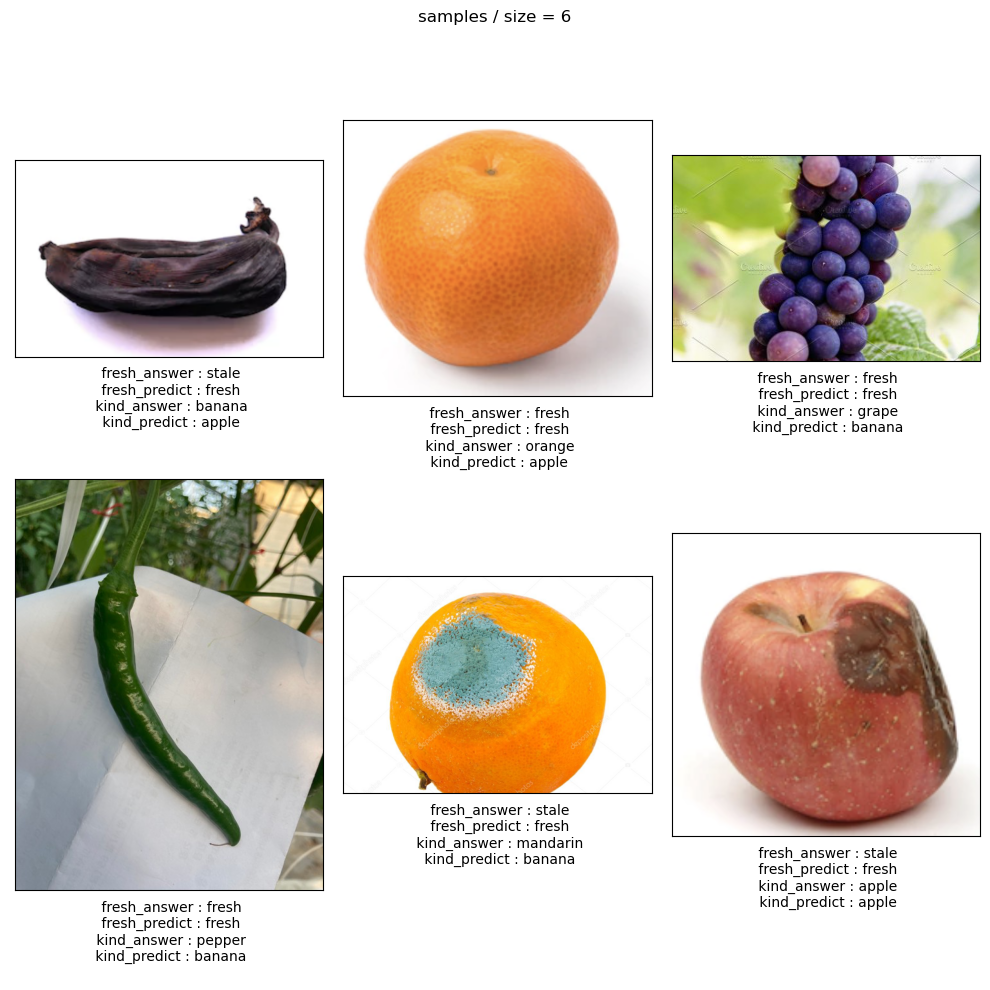

In [118]:
# ◼︎◼︎◼︎◼︎◼︎◼︎ (3) 테스트 예측내용 이미지 보기 ◼︎◼︎◼︎◼︎◼︎◼︎
dataset.view_test_img(pred_df, 6)